In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 8)

import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

In [2]:
# load dataset
dataset = pd.read_csv('dataset/spotify_tracks.csv')
dataset.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


<span style="color:blue">**NUMERICAL**</span> features of the dataset :

- <span style="color:orange">***popularity***</span>: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

- <span style="color:blue">***duration_ms***</span>: The track length in milliseconds

- <span style="color:blue">***danceability***</span>: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable

- <span style="color:blue">***energy***</span>: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale
    
- <span style="color:blue">***loudness***</span>: The overall loudness of a track in decibels (dB)
    
- <span style="color:blue">***speechiness***</span>: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
    
- <span style="color:blue">***acousticness***</span>: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
    
- <span style="color:blue">***instrumentalness***</span>: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
    
- <span style="color:blue">***liveness***</span>: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
    
- <span style="color:blue">***valence***</span>: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
    
- <span style="color:blue">***tempo***</span>: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration

In [3]:
# drop columns that are not useful
dataset.drop(columns=['Unnamed: 0', 'track_id'], inplace=True)

In [4]:
#dataset.drop_duplicates(inplace=True)

In [5]:
#dataset.head(100)

In [6]:
# drop columns corresponding to categorical features
dataset.drop(columns=['artists', 'album_name', 'track_name', 'explicit', 
                      'key', 'mode', 'time_signature', 'track_genre'], inplace=True)

In [7]:
#dataset.isnull().sum()         # to check if there are missing values
#dataset.dropna(inplace=True)   # to drop records with missing values

In [8]:
#dataset.nunique(axis=0)    # to check the number of distinct values for each column

In [9]:
X = dataset.drop(columns=['popularity'])    # features
y = dataset['popularity']                   # target variable

In [10]:
print(X.shape) 
X.describe()

(114000, 10)


,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,2.280292e+05,0.566800,0.641383,-8.258960,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837
std,1.072977e+05,0.173542,0.251529,5.029337,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197
min,0.000000e+00,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.740660e+05,0.456000,0.472000,-10.013000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750
50%,2.129060e+05,0.580000,0.685000,-7.004000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000
75%,2.615060e+05,0.695000,0.854000,-5.003000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000
max,5.237295e+06,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000


(114000,)
popularity
99         1
100        2
95         5
98         7
94         7
       ...  
1       2140
44      2288
21      2344
22      2354
0      16020
Name: count, Length: 101, dtype: int64


<Axes: >

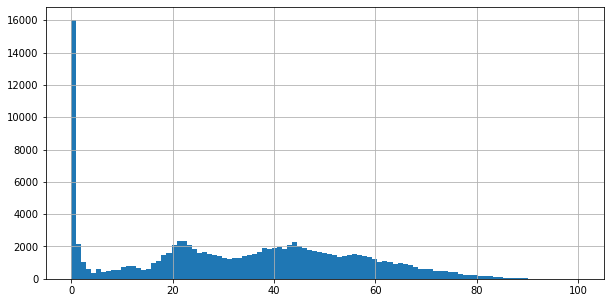

In [11]:
print(y.shape)
print(y.value_counts().sort_values())
y.hist(bins=101, figsize=(10,5))

In [12]:
X['popularity_subsamples'] = y.map(lambda x: x if x % 2 == 0 else x+1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['popularity_subsamples'])

X_train.drop(columns='popularity_subsamples', inplace=True)
X_test.drop(columns='popularity_subsamples', inplace=True)

### Features selection

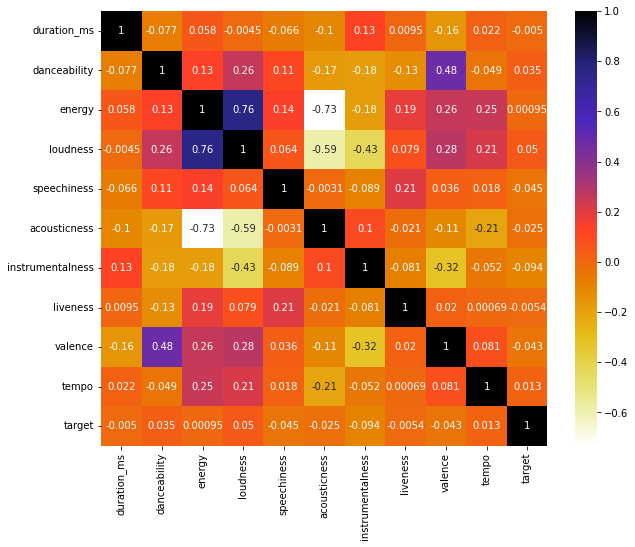

In [13]:
all_data = X_train.copy()
all_data['target'] = y_train
plt.figure(figsize=(10,8))
sns.heatmap(all_data.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

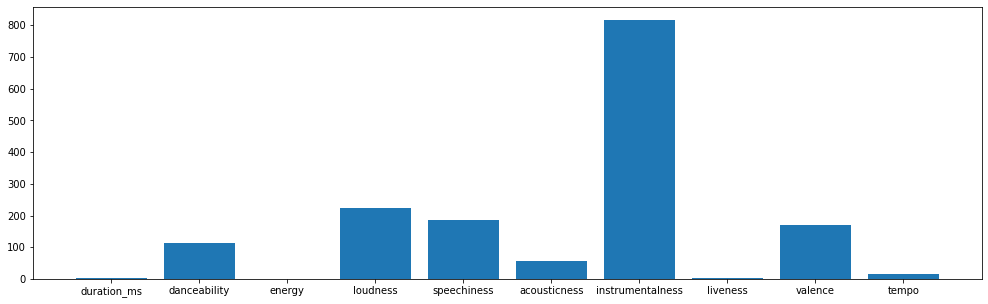

In [14]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train, y_train)

plt.figure(figsize=(17,5))
plt.bar([X_train.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [15]:
worst_features = ['duration_ms', 'energy', 'liveness', 'tempo']
X_train.drop(columns=worst_features, inplace=True)
X_test.drop(columns=worst_features, inplace=True)

### Features normalization

In [16]:
standard_scaler = preprocessing.StandardScaler().set_output(transform="pandas")

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

### *Ridge Regression* on *Spotify Tracks Dataset* 

In [17]:
from ridge_regression import RR # my implementation

In [18]:
λ_grid = np.linspace(0, 250, num=100)

learner = GridSearchCV(estimator=RR(), param_grid={'λ': λ_grid}, scoring='neg_mean_squared_error', cv=5)
learner.fit(X_train, y_train)

print('best λ :', learner.best_params_['λ'])

best λ : 73.23232323232322


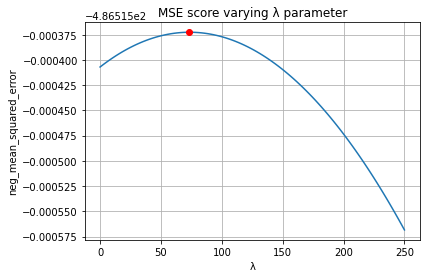

In [19]:
fig, ax = plt.subplots()
ax.plot(learner.cv_results_['param_λ'].data, 
        learner.cv_results_['mean_test_score'])
ax.plot(learner.best_params_['λ'], learner.best_score_, 'ro') 
ax.set(xlabel='λ', ylabel='neg_mean_squared_error', title='MSE score varying λ parameter')
ax.grid()
plt.show()

In [20]:
rr = learner.best_estimator_
rr.fit(X_train, y_train)
y_prediction = rr.predict(X_test)

print('   MSE :', mean_squared_error(y_test, y_prediction))
print('   MAE :', mean_absolute_error(y_test, y_prediction))
print('    R2 :', r2_score(y_test, y_prediction))

   MSE : 487.34675482923825
   MAE : 18.44594005253612
    R2 : 0.020614849924539658


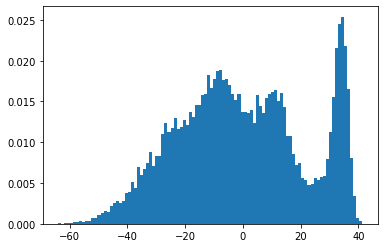

In [21]:
fig, ax = plt.subplots()
ax.hist(y_prediction - y_test, density=True, bins=100)
plt.show()

Checking that my implementation performs exactly as the one in *sklearn*

In [22]:
debug = False

if debug:

    learner = GridSearchCV(estimator=Ridge(), param_grid={'alpha': λ_grid}, scoring='neg_mean_squared_error', cv=5)
    learner.fit(X_train, y_train)

    print('best λ :', learner.best_params_['alpha'])

    learner.best_estimator_.fit(X_train, y_train)
    y_prediction = learner.best_estimator_.predict(X_test)

    print('   MSE :', mean_squared_error(y_test, y_prediction))
    print('   MAE :', mean_absolute_error(y_test, y_prediction))
    print('    R2 :', r2_score(y_test, y_prediction))

### *Kernel Ridge Regression* on *Spotify Tracks Dataset*

In [23]:
from kernel_ridge_regression import KRR # my implementation

In [24]:
train_sample_size = 5000
test_sample_size = 1000

X_train_sample = X_train.sample(n=train_sample_size, random_state=1)
y_train_sample = pd.Series(data = [y_train[i] for i in X_train_sample.index], index = X_train_sample.index)

X_test_sample = X_test.sample(n=test_sample_size, random_state=1)
y_test_sample = pd.Series(data = [y_test[i] for i in X_test_sample.index], index = X_test_sample.index)

In [25]:
"""
from sklearn.kernel_ridge import KernelRidge

krr = KernelRidge(alpha=1.0, kernel="rbf", gamma=0.5)
krr.fit(X_train_sample, y_train_sample)
y_prediction = krr.predict(X_test_sample)

print('   MSE :', mean_squared_error(y_test_sample, y_prediction))
print('   MAE :', mean_absolute_error(y_test_sample, y_prediction))
print('    R2 :', r2_score(y_test_sample, y_prediction))
"""


'\nfrom sklearn.kernel_ridge import KernelRidge\n\nkrr = KernelRidge(alpha=1.0, kernel="rbf", gamma=0.5)\nkrr.fit(X_train_sample, y_train_sample)\ny_prediction = krr.predict(X_test_sample)\n\nprint(\'   MSE :\', mean_squared_error(y_test_sample, y_prediction))\nprint(\'   MAE :\', mean_absolute_error(y_test_sample, y_prediction))\nprint(\'    R2 :\', r2_score(y_test_sample, y_prediction))\n'

In [26]:
krr = KRR()
krr.fit(X_train_sample, y_train_sample)

In [27]:
y_prediction = krr.predict(X_test_sample)

print('   MSE :', mean_squared_error(y_test_sample, y_prediction))
print('   MAE :', mean_absolute_error(y_test_sample, y_prediction))
print('    R2 :', r2_score(y_test_sample, y_prediction))

   MSE : 498.83637710954565
   MAE : 18.37845645709439
    R2 : -0.025520578894218326


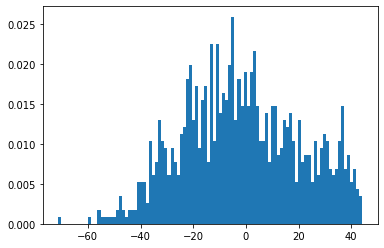

In [28]:
fig, ax = plt.subplots()
ax.hist(y_prediction - y_test_sample, density=True, bins=100)
plt.show()

In [29]:
λ_grid = 10. ** np.arange(-1, 3) 
#λ_grid = np.linspace(0, 2, num=5) 

γ_grid = 10. ** np.arange(-1, 3) 
#γ_grid = np.linspace(1, 7, num=7) 

learner = GridSearchCV(estimator=KRR(), n_jobs=-1, param_grid={'λ': λ_grid, 'γ': γ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=3)
learner.fit(X_train_sample, y_train_sample)

print('best λ :', learner.best_params_['λ'])
print('best γ :', learner.best_params_['γ'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 4/5] END ...................γ=0.1, λ=0.1;, score=-756.125 total time=   8.6s
[CV 5/5] END ...................γ=0.1, λ=0.1;, score=-763.352 total time=   8.6s
[CV 2/5] END ...................γ=0.1, λ=0.1;, score=-736.664 total time=   8.8s
[CV 1/5] END ...................γ=0.1, λ=0.1;, score=-714.480 total time=   8.8s
[CV 3/5] END ...................γ=0.1, λ=1.0;, score=-739.724 total time=   8.7s
[CV 1/5] END ...................γ=0.1, λ=1.0;, score=-672.419 total time=   8.8s
[CV 3/5] END ...................γ=0.1, λ=0.1;, score=-771.020 total time=   9.1s
[CV 2/5] END ...................γ=0.1, λ=1.0;, score=-714.742 total time=   9.5s
[CV 5/5] END ...................γ=0.1, λ=1.0;, score=-733.063 total time=   8.5s
[CV 3/5] END .................γ=0.1, λ=10.0;, score=-1024.005 total time=   8.4s
[CV 1/5] END ..................γ=0.1, λ=10.0;, score=-913.654 total time=   8.5s
[CV 2/5] END ..................γ=0.1, λ=10.0;, s

In [30]:
#learner.cv_results_

In [31]:
score = learner.cv_results_['mean_test_score']
#score

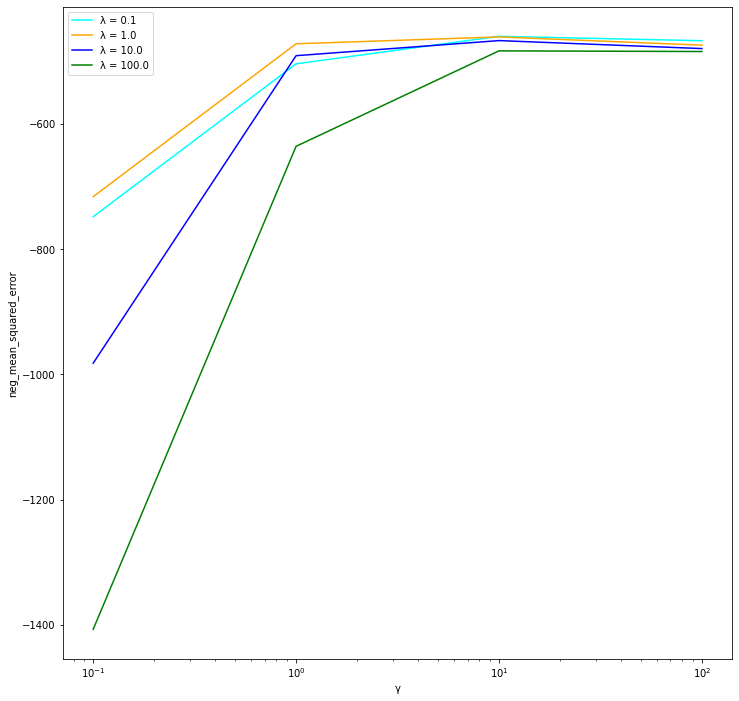

In [32]:
dict_λ = {}
for v in set(learner.cv_results_['param_λ'].data):
    dict_λ[v] = (sorted(set(learner.cv_results_['param_γ'].data)), [])
for i, p in enumerate(learner.cv_results_['params']):
    dict_λ[p['λ']][1].append(score[i])
#del(dict_λ[0.0])

plt.figure(figsize=(12,12))

colors = ['red', 'purple', 'green', 'blue', 'orange', 'cyan'] * 5
for k in sorted(dict_λ.keys()):
    plt.plot(dict_λ[k][0], dict_λ[k][1], label = f"λ = {k}", linestyle="-", color = colors.pop())

plt.xscale("log")
plt.xlabel("γ")
plt.ylabel("neg_mean_squared_error")
plt.legend()
plt.show()

In [33]:
#dict_λ

In [34]:
krr = learner.best_estimator_
krr.fit(X_train_sample, y_train_sample)
y_prediction = krr.predict(X_test_sample)

print('   MSE :', mean_squared_error(y_test_sample, y_prediction))
print('   MAE :', mean_absolute_error(y_test_sample, y_prediction))
print('    R2 :', r2_score(y_test_sample, y_prediction))

   MSE : 475.7939184256754
   MAE : 18.03237483089223
    R2 : 0.021850696844638584


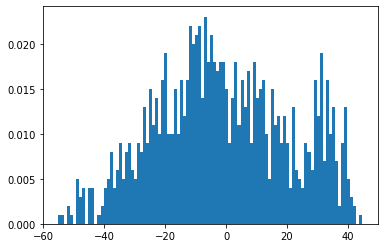

In [35]:
fig, ax = plt.subplots()
ax.hist(y_prediction - y_test_sample, density=True, bins=100)
plt.show()